# Encoding circuits for stabilizer codes

<div style="width:100%;text-align:right;font-size:0.75em;opacity:0.2">Latex macros</div>
$\newcommand{\ket}[1]{|#1\rangle} $
$\newcommand{\bra}[1]{\langle #1|} $
$\newcommand{\iu}{{i\mkern1mu}}$
$\newcommand{\e}{\mathrm{e}}$
$\newcommand{\bigo}{\mathcal{O}}$
$\newcommand{\set}[1]{\{#1\}}$
$\newcommand{\oper}[1]{\mathcal{#1}}$
$\newcommand{\st}[1]{\mathcal{#1}}$
$\newcommand{\vecs}[1]{\mathcal{#1}}$
$\newcommand{\group}[1]{\mathcal{#1}}$
$\newcommand{\union}{\hspace{0.25em}\cup\hspace{0.25em}}$

Here, we present an algorithm to construct the encoding circuit for stabilizer codes. We will use the Steane code as the guiding example.

## Gottesman's method to construct logical zero state of stabilizer codes
There is a very systematic method for creating the logical zero state using the stabilizer generator matrix. The method is a three part process.

1. Bring the generator matrix to standard form.
2. Construct logical operators of the code.
3. Use Gottesman's algorithm to determine the sequence of gates in the encoding circuit.

Let's load up the Steane code.

In [1]:
import stac

In [2]:
cd = stac.CommonCodes.generate_code('[[7,1,3]]')
stac.print_matrix(cd.generator_matrix, augmented=True)

<IPython.core.display.Math object>

### 1. Bring the generator matrix to standard form
The matrix above is the generator matrix $G$ of the Steane code. It has $m=6$ generators/row, and $2n=14$ columns, so $n=7$ physical qubits. And it encodes $k=n-m=1$ logical qubit.

We will now transform it to the standard form. What does this mean? Note that each row of $H$ represents a generator of the stabilizer group associated with the Steane code. We can manipulate the generators and qubits in the following way.

* We know from group theory that we can replace one of the generators $g_i$ with $g_ig_j$ where $g_j$ is another generator, and we will have obtained a new generating set for the same group. Multiplying generators corresponds to adding rows of $G$ (why?). 
* We can also reindex the generators, which corresponds to permuting the rows $G$. 
* We can also reindex the physical qubits, which corresponds to simultaneously permuting the columns on both sides of $G$. 

All of these operations on the generators don't change the code, only create a new representation of it. The corresponding operations on $G$ are simply those that we do when doing Gaussian reduction on a matrix. Recall that any matrix can brought into a reduced row echelon form (RREF), which is unique. We will use this fact to create the standard from of $G$. The goal is to simplify the generators so they have as few Paulis in them as possible.

The standard form is obtained as follows. First bring the $X$ part of $G$ to RREF, remembering to permute columns on both sides. This reduces $G$ to
\begin{equation}
G = \left(\begin{array}{cc|cc}
I & A & B & C \\
0 & 0 & D & E
\end{array}\right).
\end{equation}
Let $r$ be the rank of the $X$ part of $G$. Then, the blocks have

* $r$ and $m-r$ rows respectively,
* $r$ and $n-r$ columns respectively.

If we then bring $E$ to RREF, due to the properties of the code, $G$ will reduce to
\begin{equation}
G = \left(\begin{array}{ccc|ccc}
I & A_1 & A_2 & B & C_1 & C_2 \\
0 & 0   & 0   & D & I   & E_2
\end{array}\right).
\end{equation}
Here, the colums of the blocks are of size $r$, $m-r$ and $k$ respectively.

This is the standard form of $G$. For the Steane code, it is as follows.

In [3]:
cd.construct_standard_form()
stac.print_matrix(cd.standard_generator_matrix, augmented=True)

<IPython.core.display.Math object>

#### Task 1
Identify $A_1, A_2, B, C_1, C_2, D$ and $E_2$ for the matrix above.

### 2. Construct logical operators of the code
Logical operators are operators that act directly on the encoded state. For instance, the logical $\bar{X}$ acts as follows on the encoded basis states $\ket{\bar 0}$ and $\ket{\bar 1}$.
\begin{align}
 \bar{X}\ket{\bar 0} &= \ket{\bar 1}, \\
 \bar{X}\ket{\bar 1} &= \ket{\bar 0}.
\end{align}
Similarly, the logical $\bar{Z}$ acts as follows.
\begin{align}
 \bar{Z}\ket{\bar 0} &= \ket{\bar 0}, \\
 \bar{Z}\ket{\bar 1} &= -\ket{\bar 1}.
\end{align}

For a stabilizer code, Gottesman's presented a method to construct them. The claim is that, the logical $\bar{X}$s are the rows of the matrix
\begin{equation}
\bar{X} = \begin{pmatrix}
0 & E_2^T & I & | & (E_2^TC_1^T + C_2^T) & 0 & 0
\end{pmatrix}.
\end{equation}
Remember that some codes encode more than one logical qubit, so if a code encodes $k$ logical qubit, we will need $k$ logical $\bar{X}$s.

Similarly, the logical $\bar{Z}$s are
\begin{equation}
\bar{Z} = 
\begin{pmatrix}
0 & 0 & 0 & | & A_2^T & 0 & I
\end{pmatrix}.
\end{equation}

We can read off these from $H$, and for the Steane code, they are as follows.

In [4]:
cd.construct_logical_operators()
print("Logical X =", cd.logical_xs)
stac.print_paulis(cd.logical_xs)

print("\nLogical Z =", cd.logical_zs)
stac.print_paulis(cd.logical_zs)

Logical X = [[0 0 0 0 1 1 1 0 0 0 0 0 0 0]]


<IPython.core.display.Math object>


Logical Z = [[0 0 0 0 0 0 0 1 1 0 0 0 0 1]]


<IPython.core.display.Math object>

Note that the logical $\bar{X}$ and $\bar{Z}$ are not unique. For instance, for the Steane code, the operators
\begin{align}
\bar{X} &= X_0X_1X_2X_3X_4X_5X_6, \\
\bar{Z} &= Z_0Z_1Z_2Z_3Z_4Z_5Z_6,
\end{align}
also act just as well.

#### Task 1
Use `stac` to construct the logical operators for the $[[5,1,3]]$ code.

In [5]:
#

### 3. Use Gottesman's algorithm to determine the sequence of gates in the encoding circuit
Now we are ready to construct the encoding circuit for the zero state. It's a very simple algorithm. Let there be $n$ qubits, and let

* qubits $0$ to $n-k-1$ be the ancilla qubits in state $\ket{0}$, and
* qubits $n-k$ to $n-1$ qubits ($k$ total) be in the unknown state $\ket{\psi}$, which is to be encoded. 

The algorithm is as follows.

```
encoding_circuit = stac.Circuit.simple(n)
for i in range(k):
    for j in range(r, n-k):
        if cd.logical_xs[i, j]:
            encoding_circuit.append("CX", n-k+i, j)

for i in range(r):
    encoding_circuit.append(["H", i])
    for j in range(n):
        if i == j:
            continue
        if cd.standard_generators_x[i, j] and cd.standard_generators_z[i, j]:
            encoding_circuit.append("CX", i, j)
            encoding_circuit.append("CZ", i, j)
        elif cd.standard_generators_x[i, j]:
            encoding_circuit.append("CX", i, j)
        elif cd.standard_generators_z[i, j]:
            encoding_circuit.append("CZ", i, j)
```

One subtlety here is that instead of using the complex $Y$ gate, we instead let $Y=ZX$, which is a real matrix. So, the place where we have to apply $CY$, we apply $CX$ followed by $CZ$.


Here, we will let $\ket{\psi} = \ket{0}$. Executing this algorithm, we get the circuit as follows.

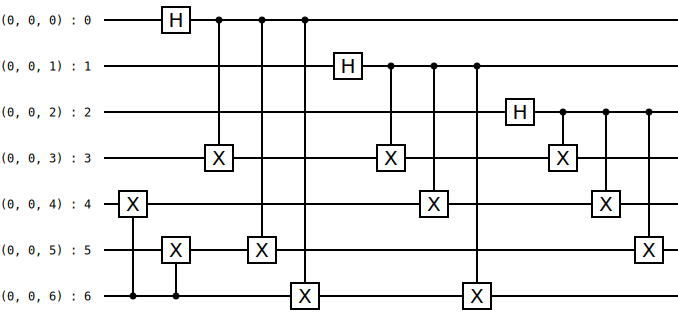

In [6]:
enc_circ = cd.construct_encoding_circuit()
enc_circ.draw()

We should check that this produces the right state. We should produce the state
$$\ket{\bar 0} = \ket{0000000} + \ket{1100110}+ \ket{1111000} + \ket{0011110}$$
$$+ \ket{1010101} + \ket{0110011}+ \ket{0101101} + \ket{1001011}.$$

In [7]:
enc_circ.simulate()

  basis    amplitude
-------  -----------
0000000        0.354
1111000        0.354
1100110        0.354
0011110        0.354
1010101        0.354
0101101        0.354
0110011        0.354
1001011        0.354


We can similarly, create the logical one state. There are two ways go about this. Either, 

1. We feed in the $\ket{1}$ state into the circuit, or 
2. We use the logical $\bar{X}$ to flip the logical zero state. 

Let's do both.

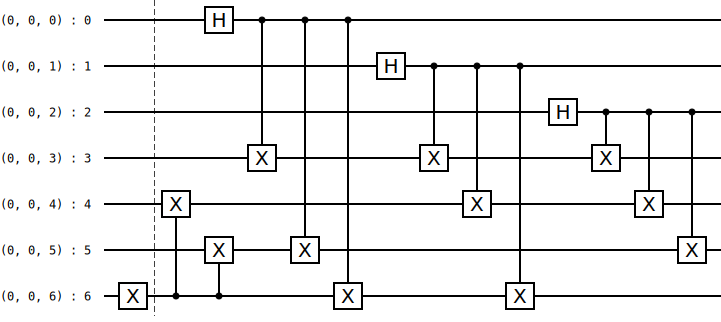

  basis    amplitude
-------  -----------
0110100        0.354
1001100        0.354
1010010        0.354
0101010        0.354
1100001        0.354
0011001        0.354
0000111        0.354
1111111        0.354


In [8]:
# Option 1
enc_circ_one = stac.Circuit.simple(cd.num_data_qubits)
enc_circ_one.append('X',6)
enc_circ_one.append('TICK')
enc_circ_one += enc_circ
enc_circ_one.draw()
enc_circ_one.simulate()
# looks good

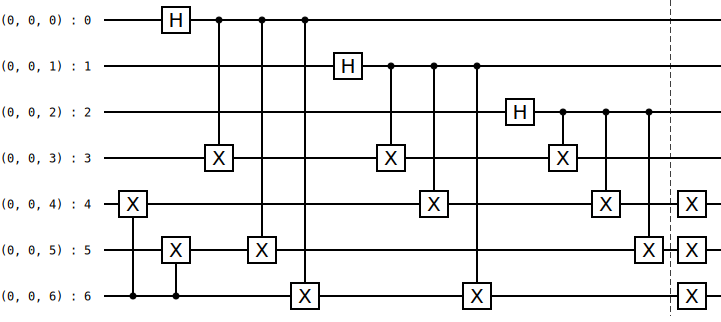

  basis    amplitude
-------  -----------
0110100        0.354
1001100        0.354
1010010        0.354
0101010        0.354
1100001        0.354
0011001        0.354
0000111        0.354
1111111        0.354


In [9]:
# Option 2. Use the logical X created above
enc_circ_flip = stac.Circuit.simple(cd.num_data_qubits)
enc_circ_flip += enc_circ
enc_circ_flip.append('TICK')
enc_circ_flip.append('X', 4)
enc_circ_flip.append('X', 5)
enc_circ_flip.append('X', 6)
enc_circ_flip.draw()
enc_circ_flip.simulate()
# looks good

#### Task 2
Use `stac` to create the encoding circuit for the $[[5,1,3]]$ code. Simulate it to determine the encoded zero and one states.

In [10]:
#